# Notebook d'inférence : AConvNet


## Importation des librairies

In [ ]:
import glob
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn import metrics


sys.path.append(str("./src"))
from src.data.MSTAR import load
from src.data.MSTAR import generate_mstar_img_json_dataset # type: ignore
from src.models._base import Model  # type: ignore
from src.models.alexnet.network import AlexNet  # type: ignore

## Choix de l'expérience

In [17]:
experiment_dir= "experiments/alexnet"
experiment_name = "alexnet-all"
dataset = 'all' # choose between (soc, eoc_1, eoc_2, confuser_rejection)

## Visualisation de l'entraînement

In [18]:
with open(f'./{experiment_dir}/history/history-{experiment_name}.json') as f:
    history = json.load(f)
# experiments/alexnet/history/history-alexnet-all.json

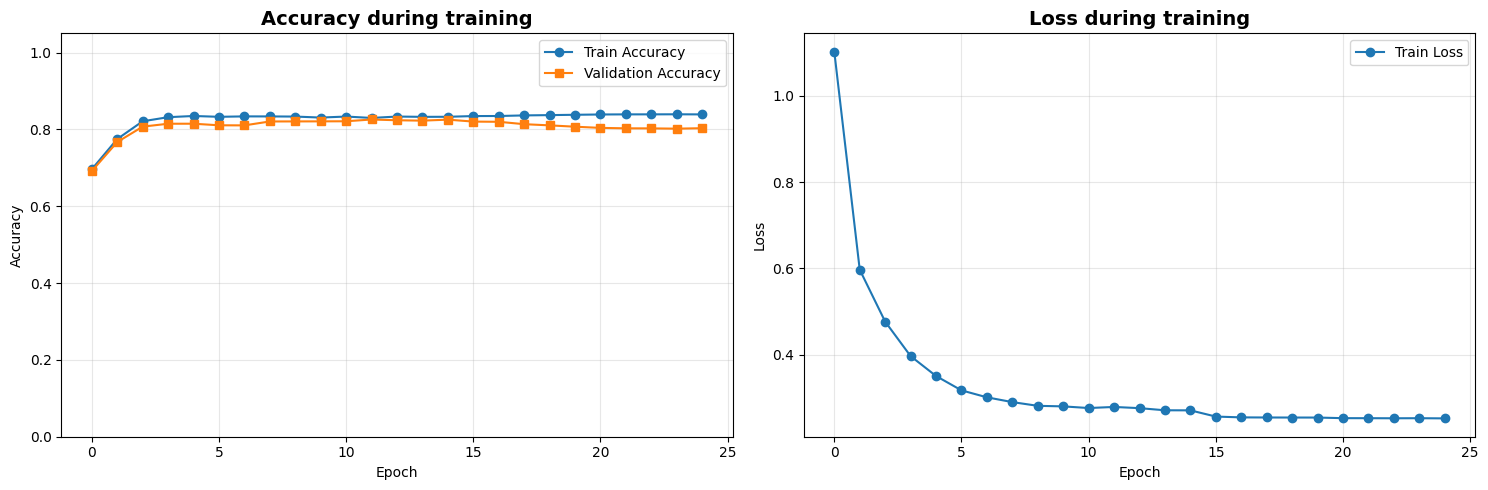

RÉSUMÉ DE L'ENTRAÎNEMENT

 MÉTRIQUES FINALES :
   Train Accuracy      : 83.8980%
   Validation Accuracy : 80.3046%
   Train Loss          : 0.253178

 MEILLEURS RÉSULTATS:
   Meilleure Val Accuracy : 82.5726 (8257.26%) à l'epoch 12

 CONVERGENCE:
   Epoch 1 → Epoch finale:
   - Train Accuracy: 69.6268 → 83.8980
   - Val Accuracy  : 69.1437 → 80.3046


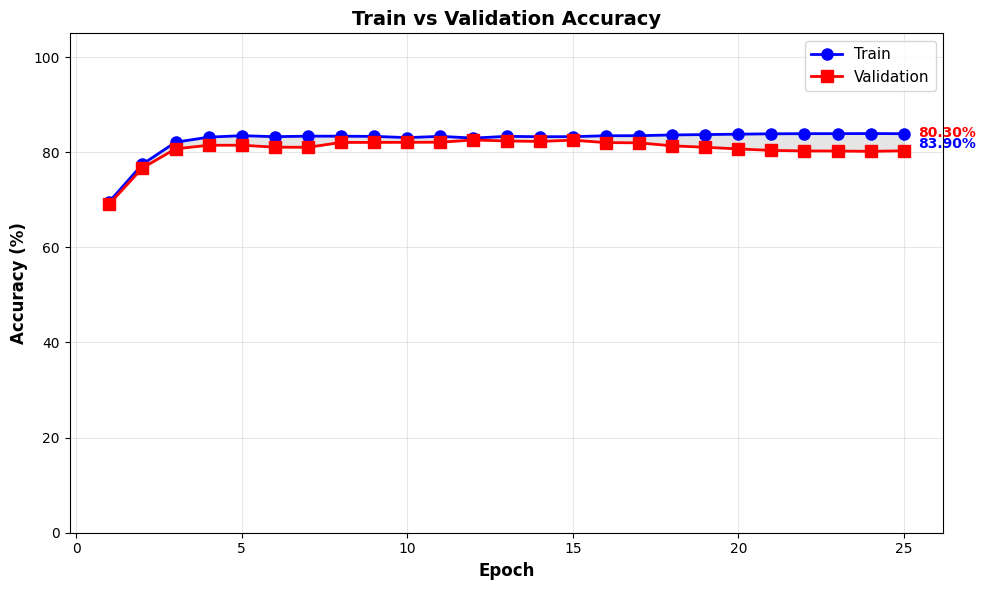

In [19]:
training_loss = history['train_loss']
training_accuracy = history['train_accuracy']
validation_accuracy = history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(np.array(training_accuracy) / 100, label='Train Accuracy', marker='o')
axes[0].plot(np.array(validation_accuracy) / 100, label='Validation Accuracy', marker='s')
axes[0].set_title('Accuracy during training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(training_loss, label='Train Loss', marker='o')
axes[1].set_title('Loss during training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./{experiment_dir}/training_curves.png')
plt.show()

print("=" * 70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 70)

# Métriques finales
final_train_acc = training_accuracy[-1]
final_val_acc = validation_accuracy[-1]
final_train_loss = training_loss[-1]

print("\n MÉTRIQUES FINALES :")
print(f"   Train Accuracy      : {final_train_acc:.4f}%")
print(f"   Validation Accuracy : {final_val_acc:.4f}%")
print(f"   Train Loss          : {final_train_loss:.6f}")

# Métriques maximales
max_val_acc = max(validation_accuracy)
max_val_acc_epoch = validation_accuracy.index(max_val_acc) + 1

print("\n MEILLEURS RÉSULTATS:")
print(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}")

# Convergence
print("\n CONVERGENCE:")
print("   Epoch 1 → Epoch finale:")
print(f"   - Train Accuracy: {training_accuracy[0]:.4f} → {final_train_acc:.4f}")
print(f"   - Val Accuracy  : {validation_accuracy[0]:.4f} → {final_val_acc:.4f}")

print("=" * 70)

# Save print output to file
summary_path = os.path.join(f'./{experiment_dir}/training_summary.txt')
with open(summary_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("RÉSUMÉ DE L'ENTRAÎNEMENT\n")
    f.write("=" * 70 + "\n")
    f.write("\n MÉTRIQUES FINALES :\n")
    f.write(f"   Train Accuracy      : {final_train_acc:.4f} ({final_train_acc*100:.2f}%)\n")
    f.write(f"   Validation Accuracy : {final_val_acc:.4f} ({final_val_acc*100:.2f}%)\n")
    f.write(f"   Train Loss          : {final_train_loss:.6f}\n")
    f.write("\n MEILLEURS RÉSULTATS:\n")
    f.write(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}\n")
    f.write("\n CONVERGENCE:\n")
    f.write("   Epoch 1 → Epoch finale:\n")
    f.write(f"   - Train Accuracy: {training_accuracy[0]:.4f} → {final_train_acc:.4f}\n")
    f.write(f"   - Val Accuracy  : {validation_accuracy[0]:.4f} → {final_val_acc:.4f}\n")
    f.write("=" * 70 + "\n")

fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, len(training_accuracy) + 1)
train_acc = np.array(training_accuracy)
val_acc = np.array(validation_accuracy)

ax.plot(epochs, train_acc, 'b-o', label='Train', linewidth=2, markersize=8)
ax.plot(epochs, val_acc, 'r-s', label='Validation', linewidth=2, markersize=8)
ax.fill_between(epochs, train_acc, val_acc, alpha=0.2, color='gray')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Annoter le dernier point
ax.annotate(f'{train_acc[-1]:.2f}%',
            xy=(epochs[-1], train_acc[-1]),
            xytext=(10, -10),
            textcoords='offset points',
            fontweight='bold',
            color='blue')
ax.annotate(f'{val_acc[-1]:.2f}%',
            xy=(epochs[-1], val_acc[-1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontweight='bold',
            color='red')

plt.tight_layout()
plt.show()


## Évaluation sur test set

In [ ]:
with open(f'./{experiment_dir}/config/{experiment_name}.json') as f:
    config = json.load(f)

model_name = config['model_name']
model_str = 'AConvNet'
dataset_path = 'datasets/MSTAR/MSTAR_IMG_JSON'

train_data_loader, val_data_loader = load.load_dataset(
    data_path=dataset_path,
    name=config['dataset'],
    is_train=True,
    batch_size=config["batch_size"],
    proportion=0.3, # ! proportion of data used for training
    augment=True
)

net = AlexNet(
        classes=config['num_classes'],
        dropout_rate=config['dropout_rate']
    )

m = Model(
    net=net,
    lr=config['lr'], 
    lr_step=config['lr_step'],
    lr_decay=config['lr_decay'],
    momentum=config['momentum'],
    weight_decay=config['weight_decay'],
    criterion=torch.nn.CrossEntropyLoss(),
)

# model_history = glob.glob(os.path.join(common.project_root, f'experiments/{model_str}/model/{model_name}/*.pth'))
model_history_path = f"./{experiment_dir}/models"
model_history = glob.glob(os.path.join(model_history_path, '*.pth'))
model_history = sorted(model_history, key=os.path.basename)
print(f"Model history list: {model_history}")

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    epoch = int(model_path.split('-')[-1].split('.')[0])
    accuracy = m.validation(val_data_loader)
    if accuracy > best['accuracy']:
        best['epoch'] = epoch
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={epoch} with {accuracy:.2f}%')

best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')


INFO: Proportionning dataset from path: datasets/MSTAR/MSTAR_IMG_JSON
INFO: Applying proportion 0.3 to dataset 'all' in mode 'train'
INFO: Class distribution before proportioning: '2S1': 897, 'BRDM2': 1192, 'T72': 1227, 'ZSU234': 598, 'BMP2': 932, 'BTR70': 932, 'ZIL131': 598, 'BTR60': 256, 'D7': 299, 'T62': 299
INFO: Class '2S1': selected 269 out of 897 samples.
INFO: Class 'BRDM2': selected 357 out of 1192 samples.
INFO: Class 'T72': selected 368 out of 1227 samples.
INFO: Class 'ZSU234': selected 179 out of 598 samples.
INFO: Class 'BMP2': selected 279 out of 932 samples.
INFO: Class 'BTR70': selected 279 out of 932 samples.
INFO: Class 'ZIL131': selected 179 out of 598 samples.
INFO: Class 'BTR60': selected 76 out of 256 samples.
INFO: Class 'D7': selected 89 out of 299 samples.
INFO: Class 'T62': selected 89 out of 299 samples.
load train data set: 100%|██████████| 2164/2164 [00:00<00:00, 2536.10it/s]


Augmenting training data with patches...


Train augmentation: 100%|██████████| 2164/2164 [00:04<00:00, 448.51it/s]



Résultats augmentation :
  Train : 2164 images → 106036 patches
  Facteur : ~49x (13x13 = 169 patches/image)

First batch shapes:
  Images: torch.Size([128, 1, 227, 227]), dtype: torch.float32
  Labels: torch.Size([128]), dtype: torch.int64
  Labels values: [1, 0, 0, 8, 0, 3, 2, 3, 6, 9]
  Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Device used: cpu
Model history list: ['./experiments/alexnet/models/model-012.pth']


100%|██████████| 166/166 [27:08<00:00,  9.81s/it]

Best accuracy at epoch=12 with 69.87%
Final model is epoch=12 with accurayc=69.87%
Path=./experiments/alexnet/models/model-012.pth


In [ ]:
def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for data in tqdm(ds, total=len(ds)):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _pred += predictions.cpu().tolist()
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)

    classification_report = metrics.classification_report(_gt, _pred)

    print(classification_report)

    clf_report_path = os.path.join(f'./{experiment_dir}/classification_report.txt')
    with open(clf_report_path, 'w') as f:
        f.write(classification_report)
    
    return conf_mat

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      3915
           1       0.77      0.65      0.71      4087
           2       0.65      0.62      0.63      3653
           3       0.66      0.69      0.68      3990
           4       0.46      0.59      0.52      1546
           5       0.99      0.99      0.99       826
           6       1.00      1.00      1.00       864
           7       0.38      0.17      0.23       621
           8       0.60      0.52      0.55       841
           9       0.54      0.49      0.51       865

    accuracy                           0.70     21208
   macro avg       0.68      0.66      0.67     21208
weighted avg       0.70      0.70      0.69     21208



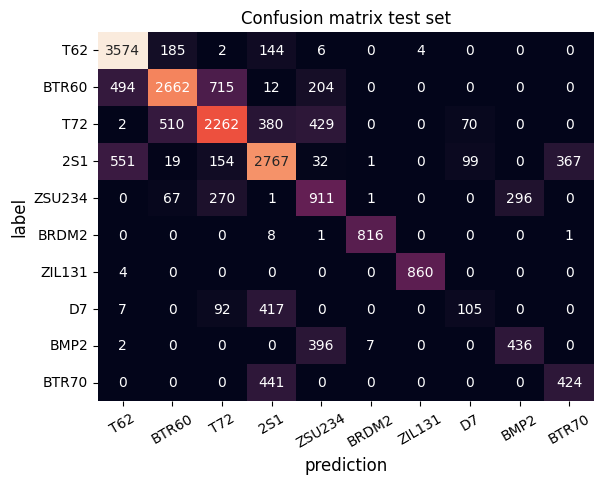

In [ ]:
# Confusion matrix
m.load(best_path)
_conf_mat = confusion_matrix(m, val_data_loader)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)

target_attr = f'target_name_{dataset}'
target_names = getattr(generate_mstar_img_json_dataset, target_attr)
ax.set_yticklabels(target_names, rotation=0)
ax.set_xticklabels(target_names, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)
plt.title('Confusion matrix test set')

plt.savefig(f'./{experiment_dir}/confusion_matrix_test.png')

plt.show()

In [24]:
## Test on one image
from typing import List

import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import clear_output, display

# input : an image uploaded by the user (if possible widget in jupyter notebook)
# 2. Define the Widget Interface
upload_btn = widgets.FileUpload(
    accept='.jpg,.png,.jpeg,.tif',  # Acceptable formats
    multiple=False,
    description='Upload SAR Image'
)
output_area = widgets.Output()


def preprocess_image(image: np.ndarray, target_size: tuple = (227, 227)) -> torch.Tensor:
    """
    Standardizes image preprocessing for inference.
    """
    # Resize with OpenCV (more efficient for NumPy arrays before tensor conversion)
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Convert to tensor: (H, W) -> (C, H, W) -> (B, C, H, W)
    tensor = torch.from_numpy(resized).float()
    
    if tensor.ndim == 2:
        tensor = tensor.unsqueeze(0)  # Add channel dim
    
    return tensor.unsqueeze(0)  # Add batch dim


def on_upload_change(change: dict) -> None:
    if not change['new']:
        return
    
    with output_area:
        clear_output(wait=True)
        
        try:
            # A. Decode
            uploaded_file = change['new'][0]
            content = uploaded_file['content']
            nparr = np.frombuffer(content, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print("Error: Could not decode image.")
                return

            # B. Display
            plt.figure(figsize=(4, 4))
            plt.imshow(image, cmap='gray')
            plt.title("Uploaded SAR Sample")
            plt.axis('off')
            plt.show()

            # C. Preprocess
            input_batch = preprocess_image(image).to(m.device)
            
            # D. Inference
            # Assuming m.inference returns raw logits
            logits = m.inference(input_batch)
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            top_prob, top_idx = torch.max(probabilities, 1)
            
            # E. Results
            # Fix: Ensure target_names is a list to avoid 'set' error
            names_list: List[str] = list(target_names) if isinstance(target_names, set) else target_names
            
            conf_value = top_prob.item()
            class_idx = top_idx.item()
            
            print("\n--- Inference Results ---")
            predicted_label = names_list[class_idx] if conf_value > 0.3 else "Rejet"
            print(f"Predicted Class: {predicted_label}")
            print(f"Confidence:      {conf_value * 100:.2f}%")
            
            print("\nFull breakdown:")
            for i, prob in enumerate(probabilities[0]):
                label = names_list[i]
                print(f"  {label:<10}: {prob.item() * 100:.2f}%")
                    
        except Exception as e:
            print(f"\n[Error] Inference failed: {e}")
            # print(f"Debug - target_names type: {type(target_names)}") # Optionnel pour debug

# 3. Link the event handler and display
upload_btn.observe(on_upload_change, names='value')
display(widgets.VBox([upload_btn, output_area]))